In [1]:
import copy

import pandas as pd
import sys
import math

sys.path.append('../Coding')
from itertools import combinations
from Algorithms import pattern_count
import time
from Algorithms import NewAlgRanking_19_20211216 as newalg
from Algorithms import NaiveAlgRanking_4_20211213 as naivealg
import numpy as np
import copy
import sys
import math
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from Algorithms import NewAlgRanking_definition2_13_20220509 as newalg2
from Algorithms import NaiveAlgRanking_definition2_5_20220506 as naivealg2

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['font.size'] = '22'

sns.set_palette("Paired")
# sns.set_palette("deep")
sns.set_context("poster", font_scale=2)
sns.set_style("whitegrid")
# sns.palplot(sns.color_palette("deep", 10))
# sns.palplot(sns.color_palette("Paired", 9))

line_style = ['o-', 's--', '^:', '-.p']
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']
# plt_title = ["BlueNile", "COMPAS", "Credit Card"]
#
# label = ["PropBounds", "IterTD"]
line_width = 8
marker_size = 20
f_size = (18, 16)
FONTSIZE=50

In [2]:
def string2num(st):
    p = list()
    idx = 0
    item = ''
    i = ''
    for i in st:
        if i == '|':
            if item == '':
                p.append(-1)
            else:
                p.append(int(item))
                item = ''
            idx += 1
        else:
            item += i
    if i != '|':
        p.append(int(item))
    else:
        p.append(-1)
    return p


def P1DominatedByP2(P1, P2):
    length = len(P1)
    for i in range(length):
        if P1[i] == -1:
            if P2[i] != -1:
                return False
        if P1[i] != -1:
            if P2[i] != P1[i] and P2[i] != -1:
                return False
    return True

def idx_of_tuples_in_group(group, data):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            return True
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    return data[data["in"] == True].index

def average_shapley_values_of_group(data, group, all_attributes, shap_values):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    tuples_idx = idx_of_tuples_in_group(group, data1).to_list()
    if len(tuples_idx) == 0:
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        print("group {} size {}".format(group, len(tuples_idx)))
        return []
    else:
        # print(tuples_idx, len(tuples_idx))
        # for id in tuples_idx:
        #     print(id, shap_values.values[id])
        avg = np.average(shap_values.values[tuples_idx], axis=0)
        # print(np.sum(shap_values.values[tuples_idx], axis=0))
        # output_file.write("\ngroup {} size {}\n".format(group, len(tuples_idx)))
        # output_file.write(str(avg))
        print("group {} size {}".format(group, len(tuples_idx)))
        # print(avg)
        return list(avg)


def idx_of_tuples_in_group_w_attribute(group, data, att, value):
    def belong_to_group(row):
        nonlocal group
        if P1DominatedByP2(row, group):
            if row[att] == value:
                return True
            else:
                return False
        else:
            return False
    data["in"] = data.apply(belong_to_group, axis=1)
    idx = data[data["in"] == True].index
    data.drop(columns=["in"], axis=1, inplace=True)
    return idx


def shapley_values_att_value_seperated(data, group, all_attributes, shap_values, output_file):
    # get all tuples in this group
    data1 = data[all_attributes].copy(deep=True)
    att_idx = 0
    for att in all_attributes:
        for v in range(int(data1.describe()[att]["min"]), int(data1.describe()[att]["max"]) + 1):
            tuples_idx = idx_of_tuples_in_group_w_attribute(group, data1, att, v).to_list()
            if len(tuples_idx) == 0:
                output_file.write("group {} att {} = {} size {}\n".format(group, att, v, len(tuples_idx)))
                print("group {} att {} = {} size {}".format(group, att, v, len(tuples_idx)))
            else:
                values_of_group = shap_values.values[tuples_idx]
                avg = np.average(values_of_group, axis=0)
                print("group {} att {} = {} size {}\n avg {}".format(group, att, v, len(tuples_idx), avg))
                output_file.write("group {} att {} = {} size {} avg {}\n".format(group, att, v, len(tuples_idx), avg[att_idx]))
        att_idx += 1

def tuples_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    tuples = data.iloc[tuple_idx]
    return tuples

def tuples_not_in_group(g, data, selected_attributes):
    tuple_idx = idx_of_tuples_in_group(g, data[selected_attributes].copy(deep=True))
    return data.drop(tuple_idx)

def check_another_group_global_bounds(g, data, selected_attributes, thc, Lowerbounds, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    if size_topk < Lowerbounds[0]:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True


def check_another_group_prop_bounds(g, data, selected_attributes, thc, alpha, k):
    size_whole_data = len(tuples_in_group(g, data, selected_attributes))
    if size_whole_data < thc:
        print("group g size too small", size_whole_data)
        return False
    size_topk = len(tuples_in_group(g, data[:k], selected_attributes))
    lowerbound = alpha * size_whole_data * k / len(data)
    print(size_whole_data, size_topk, lowerbound)
    if size_topk < lowerbound:
        print("group g doesn't have enough representation in top k", size_topk)
        return False
    return True

def plot_distribution_number(ranked_data, attribute, group, another_group, k):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    group_value_dis = [s[i] if i in s else 0 for i in x_list]
    s = ranked_data[attribute].value_counts().sort_index()
    whole_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_not_in_group(group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    other_data_dis = [s[i] if i in s else 0 for i in x_list]
    s = tuples_in_group(another_group, ranked_data, selected_attributes)[attribute].value_counts().sort_index()
    total = sum(s)
    another_group_dis = [s[i] if i in s else 0 for i in x_list]


    s = ranked_data[:k][attribute].value_counts().sort_index()
    topkdis = [s[i] if i in s else 0 for i in x_list]

    index = np.arange(len(x_list))
    bar_width = 0.2

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))

    index = np.arange(len(x_list))
    plt.bar(index, group_value_dis, bar_width, color=color[0], label="group")
    plt.bar(index + bar_width, whole_data_dis, bar_width,  color=color[2], label="whole data")
    plt.bar(index + bar_width * 2, other_data_dis, bar_width,  color=color[4], label="other data")
    plt.bar(index + bar_width * 3, another_group_dis, bar_width,  color=color[6], label="non-problematic group")
    plt.bar(index + bar_width * 4, topkdis, bar_width,  color=color[8], label="topk")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(index, x_list)

    plt.ylabel('number of tuples')
    plt.xlabel('value of attribute ' + attribute)
    # plt.yscale('log')
    plt.legend(loc='best', fontsize=25)

    plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    plt.show()



In [18]:

def plot_distribution_ratio(ranked_data, attribute, original_att, group, group_name, k, axis):
    x_list = ranked_data[attribute].unique()
    x_list.sort()
    print(x_list)

    tuples = tuples_in_group(group, ranked_data, selected_attributes)
    s = tuples[attribute].value_counts().sort_index()
    total = sum(s)
    group_value_dis = [s[i]/total if i in s else 0 for i in x_list]

    s = ranked_data[:k][attribute].value_counts().sort_index()
    total = sum(s)
    topkdis = [s[i]/total if i in s else 0 for i in x_list]

    bar_width = 0.45
    index = np.arange(len(x_list))
    print(index)
    axis.bar(index, group_value_dis, bar_width, color=color[3], label=group_name)
    axis.bar(index + bar_width, topkdis, bar_width,  color=color[7], label="top-k")
    # plt.xticks(index + bar_width, x_list)
    # plt.xticks(range(x_list[0], x_list[-1]+1))
    # index2 = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
    axis.set_xticks([0,1,2], [0,1,2], fontsize=FONTSIZE)
    axis.set_yticks([0.0, 0.5,1.0], [0.0,0.5,1.0], fontsize=FONTSIZE)
    axis.set_ylabel('Proportion', fontsize=FONTSIZE)
    axis.set_xlabel('Value of '+ original_att, fontsize=FONTSIZE)
    axis.legend(loc='upper right', fontsize=40, bbox_to_anchor=(1.02, 1.04))
    # plt.tight_layout()
    # plt.savefig("adult_time.png", bbox_inches='tight')
    # plt.show()
    return axis


In [4]:

def plot_average_shap_value_of_group(data, group, selected_attributes, all_attributes_original, shap_values, axis):
    s = average_shapley_values_of_group(data, group, selected_attributes, shap_values)

    df=pd.DataFrame({'Attribute':all_attributes_original, 'Shapley values':s})
    df.sort_values(by='Shapley values',key=abs, inplace=True,ascending=False)

    small_shap_values = df[6:]
    summary_shap_values = df[:6]

    summary_shap_values = summary_shap_values.append({'Attribute': 'other positive Shapley values', 'Shapley values': sum([x if x > 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)
    summary_shap_values = summary_shap_values.append({'Attribute': 'other negative Shapley values', 'Shapley values': sum([x if x < 0 else 0 for x in small_shap_values['Shapley values']])}, ignore_index=True)

    print(summary_shap_values)

    summary_shap_values = summary_shap_values[::-1]
    # summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], figsize=(18, 16), legend=False, fontsize=FONTSIZE, ax=axis)
    summary_shap_values.plot(kind='barh',x='Attribute',y='Shapley values',color=[color[4] if t > 0 else color[0] for t in summary_shap_values['Shapley values']], legend=False, fontsize=FONTSIZE, ax=axis)
    axis.set_ylabel('Attribute', fontsize=FONTSIZE)
    # plt.show()
    # plt.xlabel('Shapley values', fontsize=FONTSIZE)
    # plt.ylabel('Attribute', fontsize=FONTSIZE)
    # plt.tight_layout()
    # fig.set(xlabel='Shapley values')
    # return plt



# compas
description:
https://www.rdocumentation.org/packages/fairml/versions/0.6.3/topics/compas

In [5]:

all_attributes = ["age_binary", "sex_binary", "race_C",
                  "MarriageStatus_C", "juv_fel_count_C", "decile_score_C",
                  "juv_misd_count_C", "juv_other_count_C", "priors_count_C",
                  "days_b_screening_arrest_C", "c_days_from_compas_C", "c_charge_degree_C",
                  "v_decile_score_C", "start_C", "end_C", "event_C"]
# age_binary: <=35 0; else 1

all_attributes_original = ["age", "sex_binary", "race_C",
                  "MarriageStatus_C", "juv_fel_count", "decile_score",
                  "juv_misd_count", "juv_other_count", "priors_count",
                  "days_b_screening_arrest", "c_days_from_compas", "c_charge_degree_C",
                  "v_decile_score", "start", "end", "event_C"]



all_attributes_meaningful_names = ["age", "sex", "race",
                  "marriage status", "\# of juvenile felonies", "decile score",
                  "\# of juvenile misdemeanors", "\# of other juvenile convictions", "\# of prior crimes committed",
                  "days before screening arrest", "days from compas", "degree of charge",
                  "violent decile score", "start date", "end date", "event"]

original_data_file = r"../../../InputData/CompasData/general/CompasData_categorized_ranked.csv"

ranked_data = pd.read_csv(original_data_file, index_col=False)

# scoring attributes:
# c days from compas,
# juv other count, days b screening arrest, start, end,
# age, and priors count


In [6]:
ranked_data['days_b_screening_arrest'].isnull().sum()

294

In [7]:
ranked_data['c_days_from_compas'].isnull().sum()

21

In [8]:
ranked_data.isnull().sum().sum()

609

In [9]:
for att in ranked_data.columns.to_list():
    print(ranked_data[att].isnull().sum(), att)

0 juv_fel_count
0 decile_score
0 juv_misd_count
0 juv_other_count
0 priors_count
294 days_b_screening_arrest
21 c_days_from_compas
0 c_charge_degree
0 is_recid
0 is_violent_recid
0 v_decile_score
0 start
0 end
0 two_year_recid
0 Violence_score
0 Recidivism_score
0 MarriageStatus
0 age_binary
0 age_bucketized
0 sex_binary
0 race_C
294 score
0 rank
0 juv_fel_count_C
0 decile_score_C
0 juv_misd_count_C
0 juv_other_count_C
0 priors_count_C
0 days_b_screening_arrest_C
0 c_days_from_compas_C
0 c_charge_degree_C
0 v_decile_score_C
0 start_C
0 end_C
0 event_C
0 MarriageStatus_C
0 age


In [10]:
# score nan = 0
# c_days_from_compas nan = 6000
# days_b_screening_arrest nan = 500
ranked_data['score'] = ranked_data['score'].fillna(0)
ranked_data['c_days_from_compas'] = ranked_data['c_days_from_compas'].fillna(6000)
ranked_data['days_b_screening_arrest'] = ranked_data['days_b_screening_arrest'].fillna(500)

In [11]:
ranked_data.isnull().sum().sum()


0

In [12]:

# scoring attributes:
# c days from compas,
# juv other count, days b screening arrest, start, end,
# age, and priors count
selected_attributes = all_attributes[:14]

k = 49
k_min = k
k_max = k
thc = 50
Lowerbounds = [40]
time_limit = 5*60
result_global_bounds, num_patterns_visited1_, t1_ \
    = newalg.GraphTraverse(
    ranked_data[selected_attributes].copy(deep=True), selected_attributes, thc,
    Lowerbounds,
    k_min, k_max, time_limit)
groups_global_bounds = result_global_bounds[0]
for g in groups_global_bounds:
    print(g)
print(len(groups_global_bounds))

[0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, 

In [13]:
selected_attributes = all_attributes[:14]

alpha = 0.8
k = 10
k_min = k
k_max = k
thc = 50
time_limit = 5*60
result_prop_bounds, num_patterns_visited1_, t1_ \
            = newalg2.GraphTraverse(
            ranked_data[selected_attributes], selected_attributes, thc,
            alpha,
            k_min, k_max, time_limit)
groups_prop_bounds = [string2num(k) for k in result_prop_bounds[0]]
for g in groups_prop_bounds:
    print(g)


time for k_min = 12.525646686553955
finish kmin
[1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1]
[-1, -1, -1, 4, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1]
[-1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 2, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 2, -1, -1, -1, -1, -1]
[-1, -1, 0, 6, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1]
[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1]
[-1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]


In [14]:

x = ranked_data[all_attributes_original]
y = ranked_data['rank']
x.set_axis(all_attributes_meaningful_names, axis=1, inplace=True)
# with sklearn
model = LinearRegression()
model.fit(x, y)
print("Model coefficients:\n")
for i in range(x.shape[1]):
    print(x.columns[i], "=", model.coef_[i].round(5))
# compute the SHAP values for the linear model
explainer = shap.Explainer(model.predict, x)
shap_values = explainer(x)
shap_values


Model coefficients:

age = -0.08574
sex = -11.93762
race = -0.90641
marriage status = -2.49877
\# of juvenile felonies = -3.86053
decile score = 2.20108
\# of juvenile misdemeanors = 36.17001
\# of other juvenile convictions = 244.55517
\# of prior crimes committed = 138.35038
days before screening arrest = 3.41364
days from compas = 0.35291
degree of charge = 28.29349
violent decile score = 0.5237
start date = 3.46152
end date = 4.72277
event = 23.31214


Permutation explainer: 6890it [01:56, 55.93it/s]                          


.values =
array([[-2.84672945e+00,  1.91001928e+00, -4.07885312e-01, ...,
        -2.07690949e+01, -2.51747387e+03,  1.37541615e+01],
       [ 1.54340753e-01,  1.91001928e+00,  4.98526492e-01, ...,
        -2.07690949e+01, -2.51747387e+03,  1.37541615e+01],
       [ 1.01178938e+00,  1.91001928e+00,  4.98526492e-01, ...,
        -2.07690949e+01, -2.50802832e+03,  1.37541615e+01],
       ...,
       [-1.81779109e+00, -1.00276012e+01,  4.98526492e-01, ...,
        -2.07690949e+01,  2.41782337e+03, -9.55797665e+00],
       [ 2.40085616e-01,  1.91001928e+00,  4.98526492e-01, ...,
        -2.07690949e+01,  2.56895209e+03, -9.55797665e+00],
       [ 1.09753424e+00,  1.91001928e+00,  4.98526492e-01, ...,
        -2.07690949e+01,  1.12378371e+03, -9.55797665e+00]])

.base_values =
array([3363.32736525, 3363.32736525, 3363.32736525, ..., 3363.32736525,
       3363.32736525, 3363.32736525])

.data =
array([[6.900e+01, 0.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        1.000e+00],
       [3.

8
group [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 4230


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


                          Attribute  Shapley values
0                          end date     -157.589316
1      \# of prior crimes committed     -115.982101
2                        start date       18.681547
3  \# of other juvenile convictions       16.650565
4      days before screening arrest       14.902534
5                  days from compas       -4.153593
6     other positive Shapley values        4.493792
7     other negative Shapley values       -1.785900


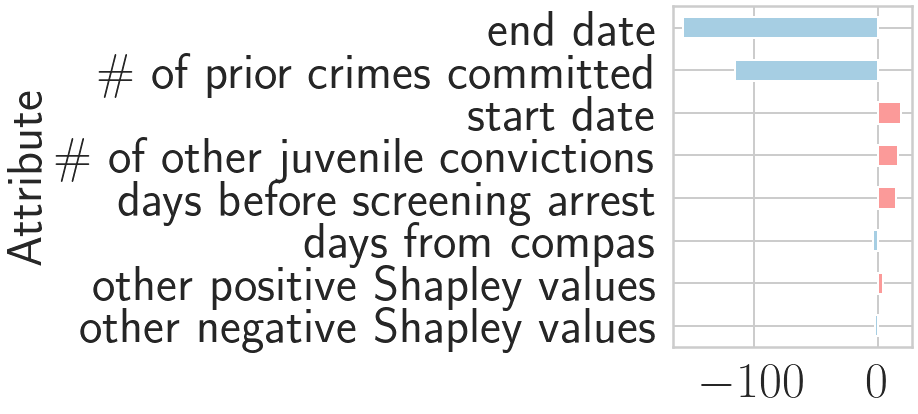

8
group [0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1] size 4230
                          Attribute  Shapley values
0                          end date     -157.589316
1      \# of prior crimes committed     -115.982101
2                        start date       18.681547
3  \# of other juvenile convictions       16.650565
4      days before screening arrest       14.902534
5                  days from compas       -4.153593
6     other positive Shapley values        4.493792
7     other negative Shapley values       -1.785900


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


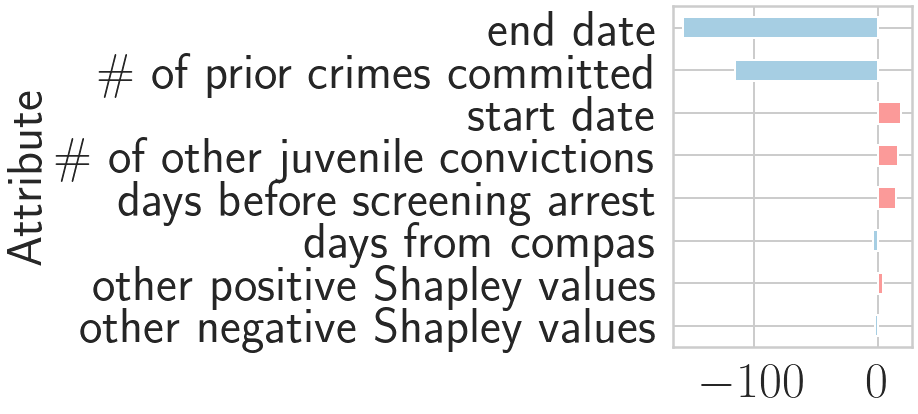

In [16]:

fig, ax = plt.subplots(1, 1,figsize=(14, 7))
group = groups_global_bounds[0]
print(len(tuples_in_group(group, ranked_data[:k], selected_attributes)))
plot_average_shap_value_of_group(ranked_data, group, selected_attributes, all_attributes_meaningful_names, shap_values, ax)
plt.tight_layout()
plt.savefig(r"compas_shap_globalbounds.png", bbox_inches='tight')



[0 1 2]
[0 1 2]


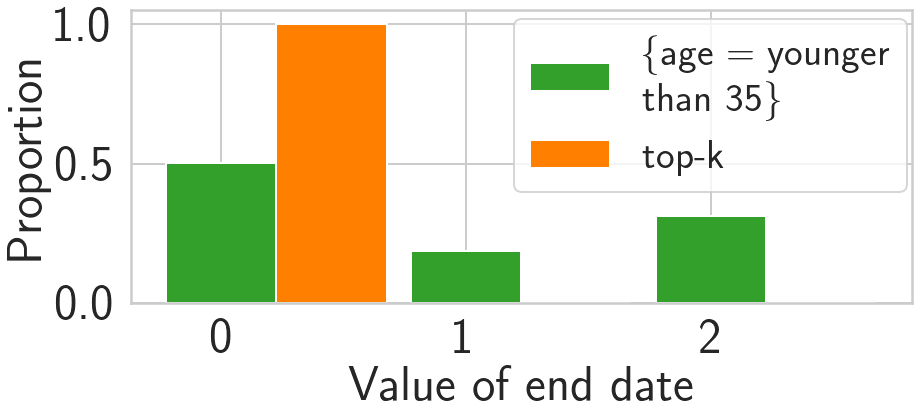

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))
original_att = 'end date'
att = all_attributes[all_attributes_meaningful_names.index(original_att)]
group_name = "\{age = younger \n than 35\}"
plot_distribution_ratio(ranked_data, att, original_att, group, group_name, k, ax)
# plt.yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], fontsize=FONTSIZE)
plt.tight_layout()
plt.savefig(r"compas_value_dis_globalbounds.png", bbox_inches='tight')
